In [1]:
import pandas as pd
import numpy as np
import io
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import make_column_transformer

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
df = pd.read_excel(url)

In [3]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Month'] = df['InvoiceDate'].dt.month
df['Year'] = df['InvoiceDate'].dt.year
df['Day'] = df['InvoiceDate'].dt.day
df['Hour'] = df['InvoiceDate'].dt.hour
df['Minute'] = df['InvoiceDate'].dt.minute
df['Invoice_str'] = df['Invoice'].astype(str)
df['CustomerID_str'] = df['Customer ID'].astype(str)
df['StockCode_str'] = df['StockCode'].astype(str)
df.dropna(how= 'any')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,Hour,Minute,Invoice_str,CustomerID_str,StockCode_str
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,85048
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323P
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,79323W
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,22041
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,7,45,489434,13085.0,21232


In [4]:
df['Quarter'] = df['InvoiceDate'].dt.quarter
df['TotalAmount'] = df['Quantity'] * df['Price']

In [5]:
# Feature Engineering Puchase Variables For Each Unique Customer

MonthlyPurchaseQuantity = df.groupby(['Customer ID', 'Month'])['Quantity'].sum().reset_index()
df = pd.merge(df, MonthlyPurchaseQuantity, on= ['Customer ID', 'Month'], suffixes= ['', '_perMonth'])

MonthlyPurchaseAmount = df.groupby(['Customer ID', 'Month'])['TotalAmount'].sum().reset_index()
df = pd.merge(df, MonthlyPurchaseAmount, on= ['Customer ID', 'Month'], suffixes= ['', '_perMonth'])

YearlyPurchaseQuantity = df.groupby(['Customer ID', 'Year'])['Quantity'].sum().reset_index()
df  = pd.merge(df, YearlyPurchaseQuantity, on= ['Customer ID', 'Year'], suffixes= ['', '_perYear'])

YearlyPurchaseAmount = df.groupby(['Customer ID', 'Year'])['TotalAmount'].sum().reset_index()
df = pd.merge(df, YearlyPurchaseAmount, on= ['Customer ID', 'Year'], suffixes= ['', '_perYear'])

In [6]:
df.columns

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country', 'Month', 'Year', 'Day', 'Hour',
       'Minute', 'Invoice_str', 'CustomerID_str', 'StockCode_str', 'Quarter',
       'TotalAmount', 'Quantity_perMonth', 'TotalAmount_perMonth',
       'Quantity_perYear', 'TotalAmount_perYear'],
      dtype='object')

What item is the best seller in every month based on the dataset?

In [7]:
monthly_sales = df.groupby(['Month', 'StockCode'])['Quantity'].sum().reset_index()
best_sellers = monthly_sales.loc[monthly_sales.groupby('Month')['Quantity'].idxmax()]
best_sellers = best_sellers.merge(df[['StockCode', 'Description']], on='StockCode', how='left')
for month in best_sellers['Month'].unique():
    item_info = best_sellers[best_sellers['Month'] == month].iloc[0]
    print(f"In month {month}, the best-selling item is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with a quantity of {item_info['Quantity']}.")

In month 1, the best-selling item is 'JAZZ HEARTS MEMO PAD' (StockCode: 20993) with a quantity of 9489.
In month 2, the best-selling item is 'BLACK AND WHITE PAISLEY FLOWER MUG' (StockCode: 37410) with a quantity of 19248.
In month 3, the best-selling item is 'SET/6 WOODLAND PAPER PLATES' (StockCode: 21091) with a quantity of 13099.
In month 4, the best-selling item is 'PACK OF 72 RETRO SPOT CAKE CASES' (StockCode: 21212) with a quantity of 5258.
In month 5, the best-selling item is 'PACK OF 12 SUKI TISSUES ' (StockCode: 21982) with a quantity of 5570.
In month 6, the best-selling item is 'WORLD WAR 2 GLIDERS ASSTD DESIGNS' (StockCode: 84077) with a quantity of 5388.
In month 7, the best-selling item is 'PACK OF 72 RETRO SPOT CAKE CASES' (StockCode: 21212) with a quantity of 4081.
In month 8, the best-selling item is 'SET/6 FRUIT SALAD PAPER CUPS' (StockCode: 21088) with a quantity of 7131.
In month 9, the best-selling item is 'BROCADE RING PURSE ' (StockCode: 17003) with a quantity of

What item is the best seller in every quarter based on the dataset?

In [8]:
quarterly_sales = df.groupby(['Quarter', 'StockCode'])['Quantity'].sum().reset_index()
best_sellers = quarterly_sales.loc[quarterly_sales.groupby('Quarter')['Quantity'].idxmax()]
best_sellers = best_sellers.merge(df[['StockCode', 'Description']], on='StockCode', how='left')
best_sellers = best_sellers[['Quarter', 'StockCode', 'Description', 'Quantity']]
for quarter in best_sellers['Quarter'].unique():
    item_info = best_sellers[best_sellers['Quarter'] == quarter].iloc[0]
    print(f"In quarter {quarter}, the best-selling item is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with a quantity of {item_info['Quantity']}.")

In quarter 1, the best-selling item is 'BLACK AND WHITE PAISLEY FLOWER MUG' (StockCode: 37410) with a quantity of 25295.
In quarter 2, the best-selling item is 'PACK OF 72 RETRO SPOT CAKE CASES' (StockCode: 21212) with a quantity of 13901.
In quarter 3, the best-selling item is 'BROCADE RING PURSE ' (StockCode: 17003) with a quantity of 16929.
In quarter 4, the best-selling item is 'WORLD WAR 2 GLIDERS ASSTD DESIGNS' (StockCode: 84077) with a quantity of 21378.


Which region is this business most successful in? Calculate the total sales for each country and find the biggest sales.

In [9]:
country_sales = df.groupby('Country')['Quantity'].sum().reset_index()
most_successful_region = country_sales.loc[country_sales['Quantity'].idxmax()]
print("The most successful region for the business is:", most_successful_region['Country'])

The most successful region for the business is: United Kingdom


Which region is this business least successful in? Calculate the total sales for each country and find the lowest sales.italicized text

In [10]:
most_successful_region = country_sales.loc[country_sales['Quantity'].idxmin()]
print("The least successful region for the business is:", most_successful_region['Country'])

The least successful region for the business is: Nigeria


What is the largest transaction on an invoice based on the dataset?

In [11]:
invoice_totals = df.groupby('Invoice')['TotalAmount'].sum().reset_index()
largest_transaction = invoice_totals.loc[invoice_totals['TotalAmount'].idxmax()]
print("The largest transaction on an invoice is: Total Amount =", largest_transaction['TotalAmount'],
      "Invoice Number =", largest_transaction['Invoice'])

The largest transaction on an invoice is: Total Amount = 44051.6 Invoice Number = 493819


What is the mean revenue of this business per month?

In [12]:
mean_revenue_per_month = df.groupby('Month')['TotalAmount'].sum().mean()
print("The mean revenue of the business per month is:", mean_revenue_per_month)

The mean revenue of the business per month is: 695684.0478333334


Calculate total revenue for this business for each month based on the dataset

In [13]:
monthly_revenue = df.groupby('Month')['TotalAmount'].sum()
for month, revenue in monthly_revenue.items():
    print(f"Month {month}: Total Revenue = {revenue}")

Month 1: Total Revenue = 531952.902
Month 2: Total Revenue = 489399.586
Month 3: Total Revenue = 635996.481
Month 4: Total Revenue = 560635.022
Month 5: Total Revenue = 559924.55
Month 6: Total Revenue = 571459.91
Month 7: Total Revenue = 562785.9
Month 8: Total Revenue = 587256.46
Month 9: Total Revenue = 781033.301
Month 10: Total Revenue = 964989.78
Month 11: Total Revenue = 1134879.2820000001
Month 12: Total Revenue = 967895.4


Calculate the average number of transactions per month for this business.

In [14]:
monthly_transactions = df.groupby('Month')['Invoice'].nunique()
average_transactions_per_month = monthly_transactions.mean()
print("The average number of transactions per month for this business is:", average_transactions_per_month)

The average number of transactions per month for this business is: 1965.5833333333333


Calculate the average total sales on the invoice for this business.

In [15]:
invoice_total_sales = df.groupby('Invoice')['TotalAmount'].sum()
average_total_sales_per_invoice = invoice_total_sales.mean()
print("The average total sales on each invoice for this business is:", average_total_sales_per_invoice)

The average total sales on each invoice for this business is: 353.9326143214483


Predict the average revenue per month by multiplying the average number of transactions (invoices) with the average total sales per invoice.

In [16]:
print(average_transactions_per_month * average_total_sales_per_invoice)

695684.0478333334


What is the best selling product for each country?

In [17]:
country_sales = df.groupby(['Country', 'StockCode'])['Quantity'].sum().reset_index()
country_best_seller = country_sales.loc[country_sales.groupby('Country')['Quantity'].idxmax()]
country_best_seller = country_best_seller.merge(df[['StockCode', 'Description']], on='StockCode', how='left')
country_best_seller.head()

,Country,StockCode,Quantity,Description
0,Australia,22951,504,60 CAKE CASES DOLLY GIRL DESIGN
1,Australia,22951,504,60 CAKE CASES DOLLY GIRL DESIGN
2,Australia,22951,504,60 CAKE CASES DOLLY GIRL DESIGN
3,Australia,22951,504,72 CAKE CASES DOLLY GIRL DESIGN
4,Australia,22951,504,60 CAKE CASES DOLLY GIRL DESIGN


In [18]:
for country in country_best_seller['Country'].unique():
  item_info = country_best_seller[country_best_seller['Country'] == country].iloc[0]
  print(f"For Country {country}, the best-selling item is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with a quantity of {item_info['Quantity']}.")

For Country Australia, the best-selling item is '60 CAKE CASES DOLLY GIRL DESIGN' (StockCode: 22951) with a quantity of 504.
For Country Austria, the best-selling item is 'MINI HIGHLIGHTER PENS' (StockCode: 16033) with a quantity of 120.
For Country Bahrain, the best-selling item is 'TOOTHPASTE TUBE PEN' (StockCode: 22422) with a quantity of 60.
For Country Belgium, the best-selling item is 'PACK OF 72 RETRO SPOT CAKE CASES' (StockCode: 21212) with a quantity of 336.
For Country Brazil, the best-selling item is 'DRAGONS BLOOD INCENSE' (StockCode: 17084P) with a quantity of 25.
For Country Canada, the best-selling item is 'JAZZ HEARTS ADDRESS BOOK' (StockCode: 20996) with a quantity of 24.
For Country Channel Islands, the best-selling item is 'JUMBO BAG PINK WITH WHITE SPOTS' (StockCode: 22386) with a quantity of 330.
For Country Cyprus, the best-selling item is 'BLUE SCANDINAVIAN PAISLEY WRAP' (StockCode: 22051) with a quantity of 200.
For Country Denmark, the best-selling item is 'BLA

What is the product that generates the most revenue for each country?

In [19]:
country_product_revenue = df.groupby(['Country', 'Description'])['TotalAmount'].sum()
best_country_product = country_product_revenue.groupby('Country').idxmax()
country_winning_product = country_product_revenue.loc[best_country_product]

country_product_revenue = df.groupby(['Country', 'StockCode'])['TotalAmount'].sum().reset_index()
best_country_product = country_product_revenue.loc[country_product_revenue.groupby('Country')['TotalAmount'].idxmax()]
best_country_product = best_country_product.merge(df[['StockCode', 'Description']], on='StockCode', how='left')

for country in best_country_product['Country'].unique():
  item_info = best_country_product[best_country_product['Country'] == country].iloc[0]
  print(f"For Country {country}, the product that generates the most revenue is '{item_info['Description']}' (StockCode: {item_info['StockCode']}) with total sales of ${item_info['TotalAmount']}.")

For Country Australia, the product that generates the most revenue is 'REGENCY CAKESTAND 3 TIER' (StockCode: 22423) with total sales of $927.0.
For Country Austria, the product that generates the most revenue is 'POSTAGE' (StockCode: POST) with total sales of $1520.0.
For Country Bahrain, the product that generates the most revenue is 'PINK HAWAIIAN PICNIC HAMPER FOR 4' (StockCode: 84797A) with total sales of $59.400000000000006.
For Country Belgium, the product that generates the most revenue is 'POSTAGE' (StockCode: POST) with total sales of $2398.0.
For Country Brazil, the product that generates the most revenue is 'FRENCH PAISLEY CUSHION COVER ' (StockCode: 20839) with total sales of $17.700000000000003.
For Country Canada, the product that generates the most revenue is 'RETRO SPOT SMALL TUBE MATCHES' (StockCode: 21584) with total sales of $33.0.
For Country Channel Islands, the product that generates the most revenue is 'AFGHAN SLIPPER SOCK PAIR' (StockCode: 51008) with total sale

Build a linear regression model that best predicts the total sales per month for this business by using appropriate variables. Compare it to the previous prediction. Calculate the MSE and r2 Score.

In [20]:
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['InvoiceDate'].dt.month
X = monthly_sales[['Month']]
y = monthly_sales['TotalAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

LMCoef = model.coef_
LMInter = model.intercept_

print("Linear Regression Model Parameters - ", "Coefficients: ", LMCoef, " Model Intercept: ", LMInter, "\n")

print("Mean Squared Error: ", mse)
print("R^2 Score: ", r2)

Linear Regression Model Parameters -  Coefficients:  [3335.62667742]  Model Intercept:  557555.7593709677 

Mean Squared Error:  111341048595.76477
R^2 Score:  -1.772067781996396


<Axes: xlabel='Month', ylabel='TotalAmount'>

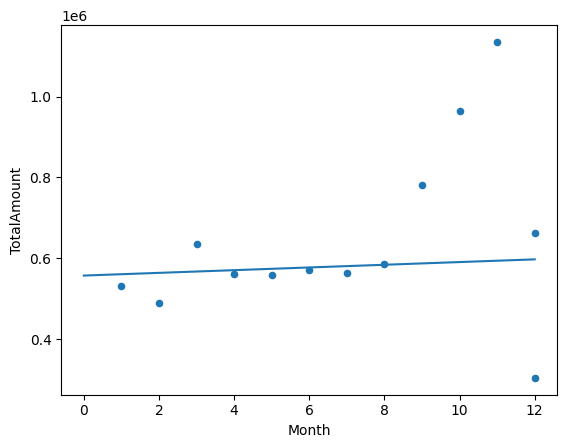

In [21]:
# Graph of Linear Regression Model

X_new = pd.DataFrame()
X_new["Month"] = np.linspace(0, 12, num=60)

# Make predictions at those feature values.
y_new_ = pd.Series(
    model.predict(X_new),
    index=X_new["Month"]
)

# Plot the predictions.
monthly_sales.plot.scatter(x="Month", y="TotalAmount")
y_new_.plot.line()

Build a KNN regression model that best predicts the total sales per month for this business by using appropriate variables. Use hyperparameter tuning to determine the best value of K to use in the model. Compare it to the previous predictions and results from the linear regression model

9    2.948222e+10
7    3.084509e+10
8    3.164792e+10
6    3.256952e+10
5    3.439297e+10
4    3.809416e+10
3    4.218976e+10
2    5.469370e+10
1    9.081590e+10
dtype: float64

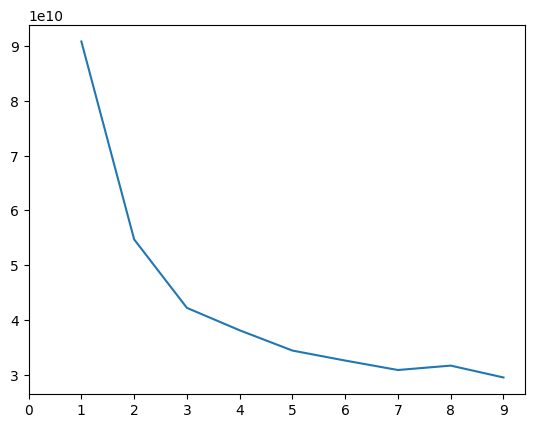

In [22]:
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalAmount'].sum().reset_index()
monthly_sales['Month'] = monthly_sales['InvoiceDate'].dt.month
X = monthly_sales[['Month']]
y = monthly_sales['TotalAmount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter Tuning for KNN Model

def get_cv_error(k):
  knn_model = make_pipeline(
      StandardScaler(),
      KNeighborsRegressor(n_neighbors=k)
  )

  cv_errs = -cross_val_score(knn_model, X=X_train, y=y_train,
                             scoring="neg_mean_squared_error", cv=10)
  return cv_errs.mean()

ks = pd.Series(range(1, 10))
ks.index = range(1, 10)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line(xticks=range(0,10))
test_errs.sort_values()

In [23]:
knn_model = KNeighborsRegressor(n_neighbors = 9)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)

print("Mean Squared Error: ", knn_mse)
print("R^2 Score: ", knn_r2)

Mean Squared Error:  117355644187.51282
R^2 Score:  -1.9218136921696947


<Axes: xlabel='Month', ylabel='TotalAmount'>

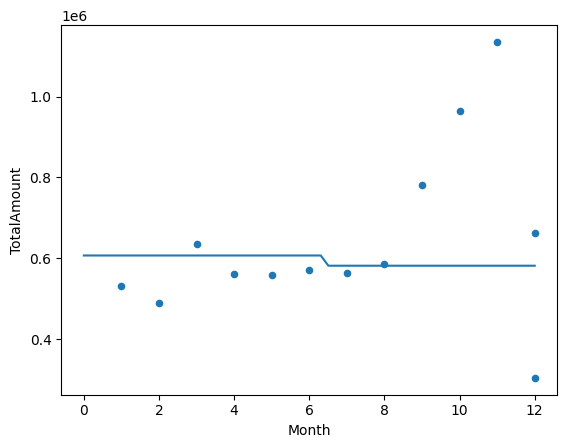

In [24]:
# Graph of KNN Model

X_new = pd.DataFrame()
X_new["Month"] = np.linspace(0, 12, num=60)

# Make predictions at those feature values.
y_new_ = pd.Series(
    knn_model.predict(X_new),
    index=X_new["Month"]
)

# Plot the predictions.
monthly_sales.plot.scatter(x="Month", y="TotalAmount")
y_new_.plot.line()

<Axes: xlabel='Month', ylabel='TotalAmount'>

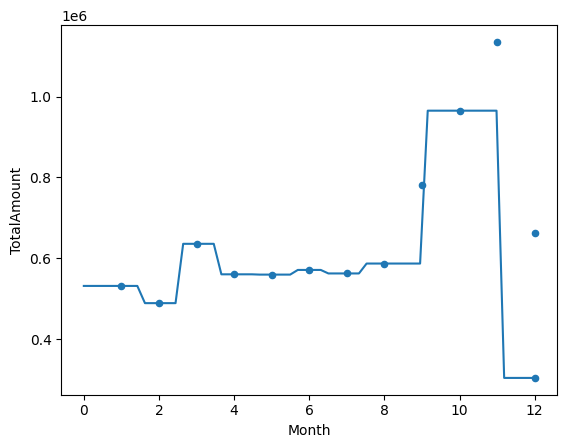

In [25]:
# KNN Model with K = 1
knn_model = KNeighborsRegressor(n_neighbors = 1)
knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)

knn_mse = mean_squared_error(y_test, y_pred)
knn_r2 = r2_score(y_test, y_pred)

X_new = pd.DataFrame()
X_new["Month"] = np.linspace(0, 12, num=60)

# Make predictions at those feature values.
y_new_ = pd.Series(
    knn_model.predict(X_new),
    index=X_new["Month"]
)

# Plot the predictions.
monthly_sales.plot.scatter(x="Month", y="TotalAmount")
y_new_.plot.line()